In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Imputing missing values and scaling values
from sklearn.preprocessing import Imputer , MinMaxScaler

# Machine Learning Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor , GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

# Hyperparameter tuning
from sklearn.model_selection import GridSearchCV , cross_val_score

# 貝葉斯調整參數
from hyperopt import hp
from hyperopt.pyll.stochastic import sample
from hyperopt import tpe
from hyperopt import Trials
from hyperopt import fmin
from hyperopt import STATUS_OK

### 讀取存檔數據

In [2]:
train_features = pd.read_csv('data/training_features.csv')
test_features = pd.read_csv('data/testing_features.csv')
train_labels = pd.read_csv('data/training_labels.csv')
test_labels = pd.read_csv('data/testing_labels.csv')

print('Training Feature Size: ', train_features.shape)
print('Testing Feature Size:  ', test_features.shape)
print('Training Labels Size:  ', train_labels.shape)
print('Testing Labels Size:   ', test_labels.shape)

Training Feature Size:  (6622, 64)
Testing Feature Size:   (2839, 64)
Training Labels Size:   (6622, 1)
Testing Labels Size:    (2839, 1)


In [3]:
train_features.head(10)

,Order,Property Id,DOF Gross Floor Area,Year Built,Number of Buildings - Self-reported,Occupancy,Site EUI (kBtu/ft²),Weather Normalized Site Electricity Intensity (kWh/ft²),Weather Normalized Site Natural Gas Intensity (therms/ft²),Water Intensity (All Water Sources) (gal/ft²),...,Largest Property Use Type_Restaurant,Largest Property Use Type_Retail Store,Largest Property Use Type_Self-Storage Facility,Largest Property Use Type_Senior Care Community,Largest Property Use Type_Social/Meeting Hall,Largest Property Use Type_Strip Mall,Largest Property Use Type_Supermarket/Grocery Store,Largest Property Use Type_Urgent Care/Clinic/Other Outpatient,Largest Property Use Type_Wholesale Club/Supercenter,Largest Property Use Type_Worship Facility
0,13276,5849784,90300.0,1950,1,100,126.0,5.2,1.2,99.41,...,0,0,0,0,0,0,0,0,0,0
1,7377,4398442,52000.0,1926,1,100,95.4,4.7,0.9,NaN,...,0,0,0,0,0,0,0,0,0,0
2,9479,4665374,104700.0,1954,1,100,40.4,3.8,0.3,NaN,...,0,0,0,0,0,0,0,0,0,0
3,14774,3393340,129333.0,1992,1,100,157.1,16.9,1.1,NaN,...,0,0,0,1,0,0,0,0,0,0
4,3286,2704325,109896.0,1927,1,100,62.3,3.5,0.0,28.65,...,0,0,0,0,0,0,0,0,0,0
5,1060,2430725,182655.0,1929,1,90,52.9,9.7,0.2,4.80,...,0,0,0,0,0,0,0,0,0,0
6,10846,5737475,65400.0,1942,1,100,66.8,3.0,0.6,67.14,...,0,0,0,0,0,0,0,0,0,0
7,4280,2670505,113150.0,1938,1,100,78.4,5.7,NaN,30.73,...,0,0,0,0,0,0,0,0,0,0
8,12974,2964670,137700.0,1959,1,100,63.0,3.4,0.5,41.96,...,0,0,0,0,0,0,0,0,0,0
9,13244,4414693,63693.0,1941,1,100,97.8,4.3,0.8,86.88,...,0,0,0,0,0,0,0,0,0,0


### 缺失值填充

在sklearn中，可以使用Scikit-learn的Imputer來進行缺失值填充<br>
對於測試集中使用訓練集中的結果來進行填充，目的在於防止[data leakage](https://www.kaggle.com/dansbecker/data-leakage)<br>
在做機器學習的題目時，應避免測試集的資訊出現再訓練集中

In [4]:
imputer = Imputer(strategy = 'median') # 以中位數來填充缺失值
imputer.fit(train_features)

X = imputer.transform(train_features)
X_test = imputer.transform(test_features)

C:\Users\peng\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [5]:
print('Missing values in training features : {}'.format(np.sum(np.isnan(X))))
print('Missing values in testing features : {}'.format(np.sum(np.isnan(X_test))))
print(np.where(~np.isfinite(X)))
print(np.where(~np.isfinite(X_test)))

Missing values in training features : 0
Missing values in testing features : 0
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))


對缺失值填充有各種各樣的方法 [this article](https://www.tandfonline.com/doi/full/10.1080/1743727X.2014.979146)

### 特徵標準化與歸一化

In [6]:
# 將數值型數據減掉最小值，在除上最大值與最小值的差
scaler = MinMaxScaler(feature_range = [0 , 1])
scaler.fit(X)
X = scaler.transform(X)
X_test = scaler.transform(X_test)

In [7]:
y = np.array(train_labels).reshape([-1 , ])
y_test = np.array(test_labels).reshape([-1 , ])

### 選擇的機器學習算法（回歸問題）

1. Linear Regression
2. Support Vector Machine Regression
3. Random Forest Regression
4. Gradient Boosting Regression
5. K-Nearest Neighbors Regression

只選擇其默認的參數，這裡先不進行調參工作，後續再來調參

In [8]:
def fit_and_evaluate(model):
    
    # Train the model
    model.fit(X, y)
    
    # Make predictions and evalute
    y_pred = model.predict(X_test)
    
    model_mae = np.mean(abs(y_test - y_pred))
    
    return model_mae

In [9]:
lr = LinearRegression()
lr_mae = fit_and_evaluate(lr)
print('Linear Regression Performance on the test set : {:.2f}'.format(lr_mae))

Linear Regression Performance on the test set : 13.47


In [10]:
svm = SVR(C = 1000 , gamma = 0.1)
svm_mae = fit_and_evaluate(svm)
print('Support Vector Machine Regression Performance on the test set : {:.2f}'.format(svm_mae))

Support Vector Machine Regression Performance on the test set : 10.93


In [11]:
random_forest = RandomForestRegressor(random_state = 60)
random_forest_mae = fit_and_evaluate(random_forest)
print('Random Forest Regression Performance on the test set : {:.2f}'.format(random_forest_mae))

C:\Users\peng\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Random Forest Regression Performance on the test set : 10.01


In [12]:
gradient_boosted = GradientBoostingRegressor(random_state = 60)
gradient_boosted_mae = fit_and_evaluate(gradient_boosted)
print('Gradient Boosted Regression Performance on the test set : {:.2f}'.format(gradient_boosted_mae))

Gradient Boosted Regression Performance on the test set : 10.01


In [13]:
knn = KNeighborsRegressor(n_neighbors = 10)
knn_mae = fit_and_evaluate(knn)
print('K-Nearest Neighbors Regression Performance on the test set : {:.2f}'.format(knn_mae))

K-Nearest Neighbors Regression Performance on the test set : 13.01


In [14]:
model_comparison = pd.DataFrame({'model': ['Linear Regression' ,  'Support Vector Machine' , 'Random Forest', 'Gradient Boosted' , 'K-Nearest Neighbors'],
                                 'mae': [lr_mae , svm_mae , random_forest_mae , gradient_boosted_mae , knn_mae]})
 
model_comparison.sort_values('mae' , ascending = False , inplace = True)

Text(0, 0.5, 'Mean Absolute')

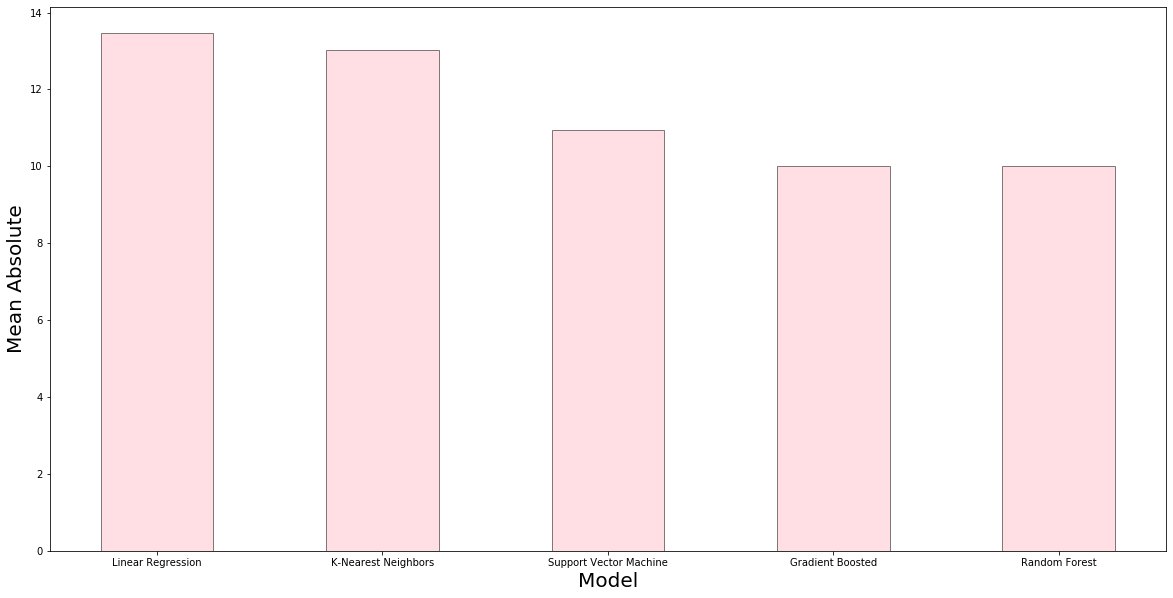

In [15]:
fig, ax = plt.subplots(1 , 1 , figsize = (20 , 10))
ax.bar(model_comparison['model'] , model_comparison['mae'] , alpha = 0.5 , width = 0.5 , facecolor = 'pink' , edgecolor = 'black')
ax.set_xlabel('Model' , fontsize = 20)
ax.set_ylabel('Mean Absolute' , fontsize = 20)

看起來集成算法更占優勢一些，但不太公平，因為參數都只用了默認<br>
而對於SVM來說參數可能影響會更大一些

### 調參

在gradient boosting算法中，先選擇6組可調參數，目的就是找到最好的組合
* `estimator`: the model
* `param_distributions`: the distribution of parameters we defined
* `cv` the number of folds to use for k-fold cross validation
* `n_iter`: the number of different combinations to try
* `scoring`: which metric to use when evaluating candidates
* `n_jobs`: number of cores to run in parallel (-1 will use all available)
* `verbose`: how much information to display (1 displays a limited amount) 
* `return_train_score`: return the training score for each cross-validation fold
* `random_state`: fixes the random number generator used so we get the same results every run

In [16]:
space = {'loss' : hp.choice('loss' , ['ls' , 'lad' , 'huber']) ,
         'n_estimators' : hp.quniform('n_estimators' , 100 , 1500 , 100) ,
         'max_depth' : hp.quniform('max_depth' , 2 , 15 , 1) ,
         'min_samples_leaf' : hp.quniform('min_samples_leaf' , 1 , 8 , 1),
         'min_samples_split' : hp.quniform('min_samples_split' , 2 , 10 , 1) ,
         'max_features' : hp.choice('max_features' , ['auto' , 'sqrt' , 'log2' , None])}

x = sample(space) # 在參數空間進行採樣
x

{'loss': 'huber',
 'max_depth': 6.0,
 'max_features': 'sqrt',
 'min_samples_leaf': 5.0,
 'min_samples_split': 6.0,
 'n_estimators': 1000.0}

In [21]:
global iteration
iteration = 0
def objective(params , n_folds = 10):   
    
    global iteration
    iteration += 1
    
    # 保證'num_leaves', 'subsample_for_bin', 'min_child_samples'都是整數值
    for parameter_name in ['n_estimators' , 'max_depth' , 'min_samples_leaf' , 'min_samples_split']:
        params[parameter_name] = int(params[parameter_name])
        
    model = GradientBoostingRegressor(n_iter_no_change = 100 , random_state = 42 , **params)
    
    cv_result = cross_val_score(estimator = model , X = X , y = y , scoring = 'neg_mean_absolute_error' , cv = n_folds)
    
    # Loss must be minimized
    loss = -1 * cv_result.mean()

    # Dictionary with information for evaluation
    return {'loss': loss , 'params': params , 'iteration': iteration , 'status': STATUS_OK}

In [22]:
# optimization algorithm
tpe_algorithm = tpe.suggest

# Keep track of results
trials = Trials()

best = fmin(fn = objective ,
            space = space ,
            algo = tpe.suggest, 
            max_evals = 25 , 
            trials = trials , 
            rstate = np.random.RandomState(42))

100%|█████████████████████████████████████████████████| 25/25 [1:40:02<00:00, 108.38s/it, best loss: 8.949369152353814]


In [31]:
# 將迭代過程以'loss'由小到大排列
trials_results_temp = sorted(trials.results , key = lambda x : x['loss'])

# 將迭代過程存到DataFrame
trials_results_ = pd.DataFrame(columns = ['loss' , 'params' , 'iteration'],
                               index = list(range(0 , 1000)))
for i in range(0 , 25):
    trials_results_.iloc[i , :] = trials_results_temp[i]
    
# 將所有結果存檔    
trials_results_.to_csv('trials_results.csv') 
trials_results_.head()

,loss,params,iteration
0,8.94937,"{'loss': 'huber', 'max_depth': 6, 'max_feature...",22
1,8.99532,"{'loss': 'huber', 'max_depth': 6, 'max_feature...",23
2,8.99532,"{'loss': 'huber', 'max_depth': 6, 'max_feature...",24
3,9.008,"{'loss': 'huber', 'max_depth': 4, 'max_feature...",4
4,9.03645,"{'loss': 'huber', 'max_depth': 7, 'max_feature...",21


In [33]:
trials_results_['params'][0] # 取得bayes search找出最好的參數

{'loss': 'huber',
 'max_depth': 6,
 'max_features': None,
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 200}

random search可以幫找大概找到合理的參數位置，但是可能沒那麽精確<br>
grid search可以更清晰的看到隨著參數的變化，對模型產生的影響，這裡先用grid search找到最優化`n_estimators`

In [65]:
# 用grid search找出最佳的'n_estimators'
trees_grid = {'n_estimators' : [100 , 150 , 200 , 250 , 300 , 350 , 400 , 450 , 500 , 550 , 600 , 650 , 700 , 750 , 800]}

model = GradientBoostingRegressor(random_state = 42 , **trials_results_['params'][0])

grid_search = GridSearchCV(estimator = model ,
                           param_grid = trees_grid ,
                           cv = 4 , 
                           scoring = 'neg_mean_absolute_error' ,
                           verbose = 1 , 
                           n_jobs = -1 ,
                           return_train_score = True)

grid_search.fit(X , y)

Fitting 4 folds for each of 15 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  7.7min finished


GridSearchCV(cv=4, error_score='raise-deprecating',
             estimator=GradientBoostingRegressor(alpha=0.9,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='huber', max_depth=6,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=10,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=200,
                                                 n_iter_no_change=None,
            

In [66]:
grid_search.best_estimator_.get_params() # 取得grid search找出最好的參數

{'alpha': 0.9,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'huber',
 'max_depth': 6,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 150,
 'n_iter_no_change': None,
 'presort': 'auto',
 'random_state': 42,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [67]:
# 按照'mean_test_score'由大排到小，也就是按照測試集的mean absolute error由小排到大
grid_results = pd.DataFrame(grid_search.cv_results_).sort_values('param_n_estimators' , ascending = True)
grid_results.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
0,6.706590,0.032590,0.008985,0.006841,100,{'n_estimators': 100},-8.840061,-8.913212,-9.288905,-9.072325,-9.028580,0.172138,8,-6.119756,-6.147452,-6.003097,-6.081047,-6.087838,0.054314
1,9.154055,0.128487,0.019527,0.006765,150,{'n_estimators': 150},-8.833716,-8.872911,-9.243285,-8.997316,-8.986767,0.159915,1,-5.417988,-5.461185,-5.353362,-5.327546,-5.390020,0.052663
2,11.715182,0.079884,0.015621,0.000002,200,{'n_estimators': 200},-8.812018,-8.899448,-9.246934,-8.997371,-8.988903,0.162738,2,-4.901738,-4.863930,-4.855831,-4.787092,-4.852148,0.041364
3,16.930806,0.199499,0.022354,0.000844,250,{'n_estimators': 250},-8.798271,-8.927945,-9.252292,-9.007841,-8.996547,0.165489,3,-4.425887,-4.441342,-4.411257,-4.316599,-4.398771,0.048620
4,20.011862,0.113585,0.026940,0.002246,300,{'n_estimators': 300},-8.819669,-8.932916,-9.229838,-9.023044,-9.001329,0.150303,5,-4.011828,-4.024887,-3.975979,-3.880787,-3.973370,0.056372
5,23.855528,0.027210,0.032412,0.007877,350,{'n_estimators': 350},-8.809260,-8.937116,-9.223967,-9.027242,-8.999358,0.151026,4,-3.624403,-3.667690,-3.614982,-3.503100,-3.602544,0.060757
6,27.156824,0.540227,0.049258,0.017590,400,{'n_estimators': 400},-8.817610,-8.942570,-9.242006,-9.069503,-9.017880,0.157063,6,-3.322902,-3.349726,-3.323837,-3.241654,-3.309530,0.040640
7,28.655193,0.352740,0.033411,0.002174,450,{'n_estimators': 450},-8.835200,-8.951433,-9.243256,-9.071770,-9.025375,0.151043,7,-3.003683,-3.049368,-3.049979,-2.951873,-3.013726,0.040346
8,30.070753,0.235305,0.036534,0.002376,500,{'n_estimators': 500},-8.849350,-8.952651,-9.247787,-9.095338,-9.036241,0.150131,10,-2.739503,-2.824883,-2.811480,-2.718249,-2.773529,0.045528
9,35.215019,0.425933,0.042213,0.012792,550,{'n_estimators': 550},-8.849384,-8.940832,-9.239943,-9.104706,-9.033674,0.150144,9,-2.518448,-2.622578,-2.644102,-2.494813,-2.569985,0.064355


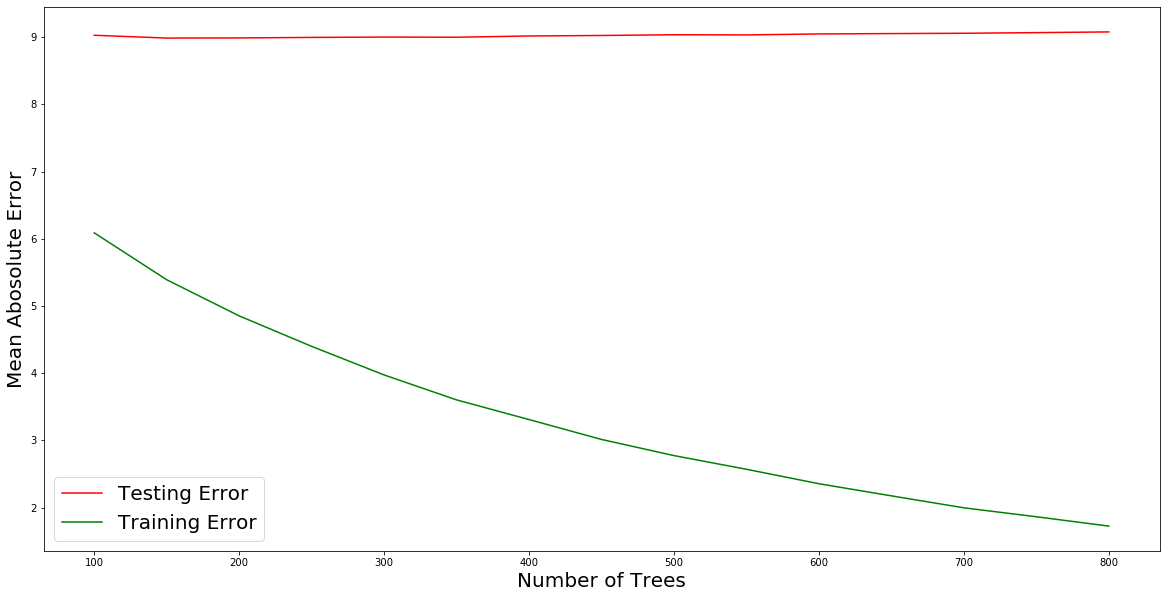

In [68]:
fig, ax = plt.subplots(1 , 1 , figsize = (20 , 10))
ax.plot(grid_results['param_n_estimators'] , -1 * grid_results['mean_test_score'] , color = 'red' , label = 'Testing Error')
ax.plot(grid_results['param_n_estimators'] , -1 * grid_results['mean_train_score'] , color = 'green' , label = 'Training Error')
ax.set_xlabel('Number of Trees' , fontsize = 20)
ax.set_ylabel('Mean Abosolute Error' , fontsize = 20)
ax.legend(fontsize = 20)

從上圖中可以明顯看出模型出現了過擬合現象，隨著樹的個數增多，過擬合現象越來越明顯

### 測試模型

In [69]:
# 預設model
default_model = GradientBoostingRegressor(random_state = 42)
default_model.fit(X , y)

# 利用random search與grid search調參的model
best_model = GradientBoostingRegressor(**grid_search.best_estimator_.get_params())
best_model.fit(X , y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='huber', max_depth=6,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=10,
                          min_weight_fraction_leaf=0.0, n_estimators=150,
                          n_iter_no_change=None, presort='auto',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

比較預設model & random search與grid search調參的model

In [70]:
default_pred = default_model.predict(X_test)
best_pred = best_model.predict(X_test)

print('Default model performance on the test set : {:.3f}'.format(np.mean(abs(y_test - default_pred))))
print('Best model performance on the test set : {:.3f}'.format(np.mean(abs(y_test - best_pred))))

Default model performance on the test set : 10.013
Best model performance on the test set : 9.164


對比試驗結果，訓練時間差異較大但是模型差不多得到了10%的提升<br>
通常來說訓練時間只要可以容忍都是可以的，模型的提升還是很寶貴的

觀察真實值與預測值的分布情況

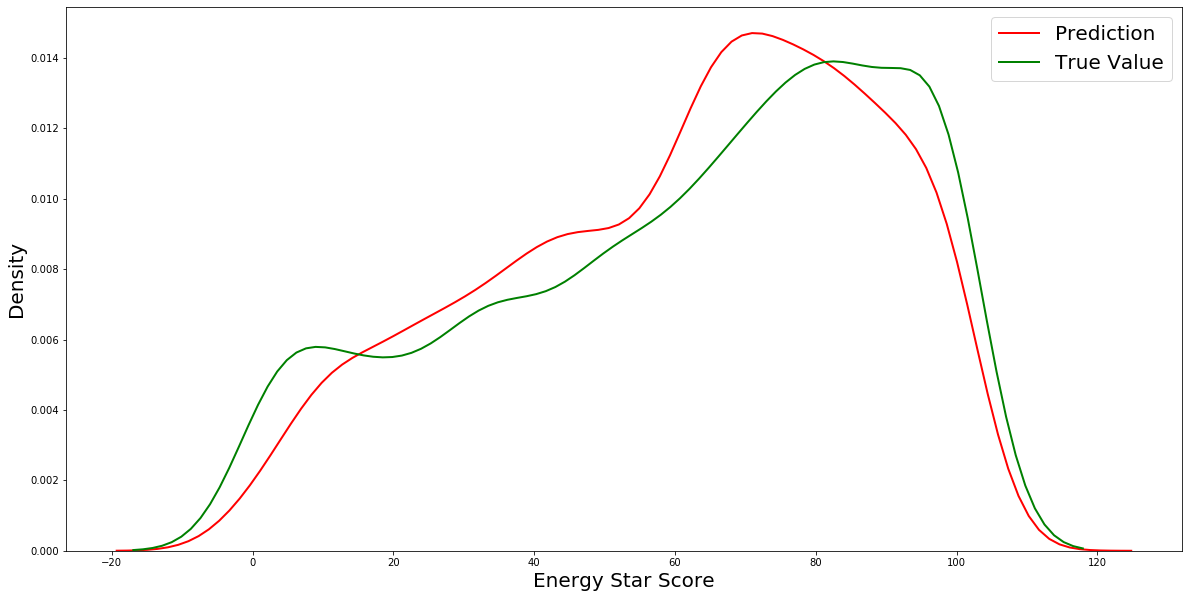

In [71]:
fig, ax = plt.subplots(1 , 1 , figsize = (20 , 10))

sns.kdeplot(best_pred , label = 'Prediction' , color = 'red' , linewidth = 2 , ax = ax)
sns.kdeplot(y_test , label = 'True Value' , color = 'green' , linewidth = 2 , ax = ax)

ax.set_xlabel('Energy Star Score' , fontsize = 20)
ax.set_ylabel('Density' , fontsize = 20)
ax.legend(fontsize = 20)

Text(0, 0.5, 'count')

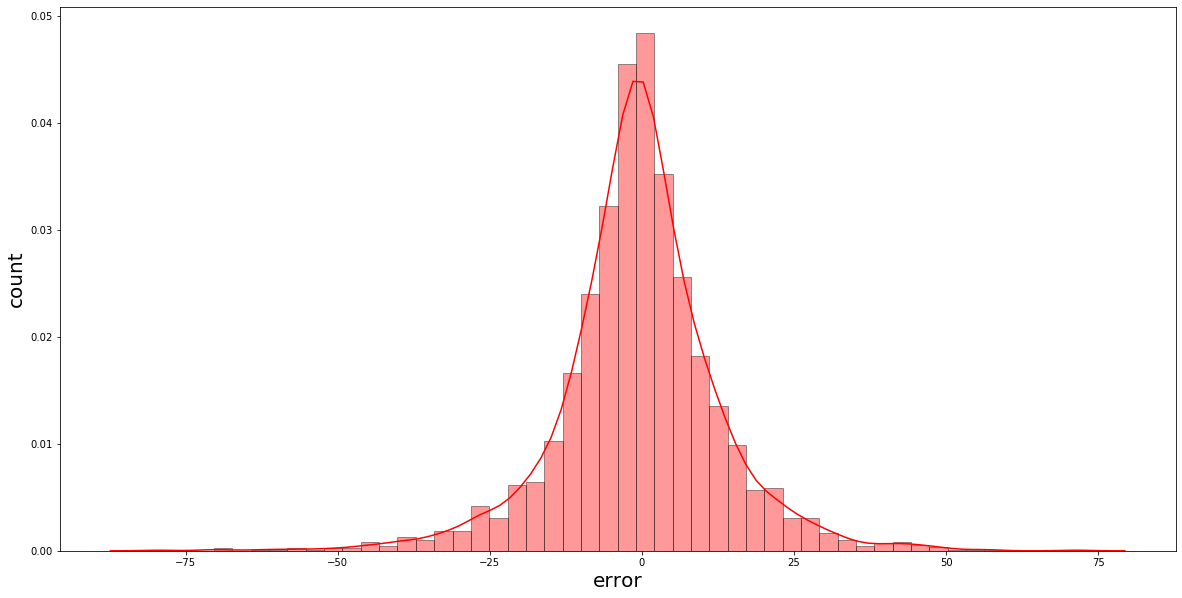

In [72]:
# 計算殘差
residuals = best_pred - y_test

fig , ax = plt.subplots(1 , 1 , figsize = (20 , 10))
sns.distplot(residuals , color = 'red' , bins = 50 ,  ax = ax , hist_kws = {'edgecolor' : 'k'})
ax.set_xlabel('error' , fontsize = 20)  
ax.set_ylabel('count' , fontsize = 20)  

殘差分布情況<br>
可以發現error在0附近是最高的